In [1]:
import os
import sys

import numpy as np
import pandas as pd

from skimage.transform import resize
from skimage.io import imread

import skimage.io

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap
np.random.seed(1234)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
STAGE1_TRAIN = "input/train"
STAGE1_TEST = "input/test2"
STAGE1_TRAIN_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK_PATTERN = "%s/{}/masks/*.png" % STAGE1_TRAIN
STAGE1_TEST_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TEST
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
TOTAL_MASK = "total_masks"

In [3]:
def image_ids_in(root_dir, ignore=[]):
    ids = []
    for id in os.listdir(root_dir):
        if id in ignore:
            print('Skipping ID:', id)
        else:
            ids.append(id)
    return ids

In [12]:
def read_image(image_id, space="rgb", train=True):
    if train:
        image_file = STAGE1_TRAIN_IMAGE_PATTERN.format(image_id, image_id)
    else:
        image_file = STAGE1_TEST_IMAGE_PATTERN.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    # Drop alpha which is not used
    if space == "hsv":
        image = skimage.color.rgb2hsv(image)
    return image

In [13]:
def read_image_labels(image_id, space="rgb", flag=True):
    image = read_image(image_id, space = space, train=flag)
    return image

In [14]:
train_image_ids = image_ids_in(STAGE1_TRAIN)
test_image_ids = image_ids_in(STAGE1_TEST)

In [15]:
def get_domimant_colors(img, top_colors=2):
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

In [35]:
def get_images_details(image_ids, flag=True):
    details = []
    for image_id in image_ids:
        image_rgb = read_image_labels(image_id, space="rgb", flag=flag)
        try:
            height, width, l = image_rgb.shape
        #dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=2)
        #dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
            g = np.mean(image_rgb[:,:,0])
            grm = np.mean(image_rgb[:,:,1]-image_rgb[:,:,0])
            grs = np.std(image_rgb[:,:,1]-image_rgb[:,:,0])
            info = (image_id, width, height, [g,grm, grs])
            details.append(info)
        except:
            g = np.mean(image_rgb[:,:])
            grm = np.mean(image_rgb[:,:]-image_rgb[:,:])
            grs = np.std(image_rgb[:,:]-image_rgb[:,:])
            info = (image_id, width, height, [g,grm, grs])
            details.append(info)
            plt.imshow(image_rgb)
    return details

In [36]:
META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT]
COLS = META_COLS + [HSV_DOMINANT]

In [52]:
len(train_image_ids)

670

In [53]:
len(test_image_ids)

3019

In [37]:
tr_details = get_images_details(train_image_ids)

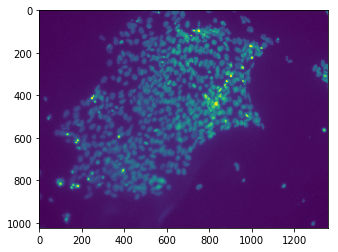

In [38]:
te_details = get_images_details(test_image_ids, flag=False)

In [39]:
trainPD = pd.DataFrame(tr_details, columns=COLS)
X = (pd.DataFrame(trainPD[HSV_DOMINANT].values.tolist())).as_matrix()
kmeans = KMeans(n_clusters=4).fit(X)
clusters = kmeans.transform(X)
trainPD[HSV_CLUSTER] = np.argmin(clusters, -1)
testPD = pd.DataFrame(te_details, columns=COLS)
Xte = (pd.DataFrame(testPD[HSV_DOMINANT].values.tolist())).as_matrix()
clusterste = kmeans.transform(Xte)
testPD[HSV_CLUSTER] = np.argmin(clusterste, -1)

In [40]:
trainPD.head()

image_id  width  height  \
0  351771edfc5db5665ded8aa4940257276b6526663c76e3...    696     520   
1  fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4...    256     256   
2  3582166ee20755856adf4882a8bfacb616fce424791160...    256     256   
3  c0f172831b8017c769ff0e80f85b096ac939e79de3d524...    320     256   
4  1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b...    256     256   

                                        hsv_dominant  hsv_cluster  
0                     [22.337353558797524, 0.0, 0.0]            0  
1                     [10.679397583007812, 0.0, 0.0]            0  
2                     [21.933761596679688, 0.0, 0.0]            0  
3  [178.859375, 161.29066162109376, 103.867312021...            3  
4                      [18.93389892578125, 0.0, 0.0]            0

In [41]:
testPD.head()

image_id  width  height  \
0  45ab35f6951ccedf48f346ae7a9bc117a7479a46636b4d...    696     520   
1  e8247dc63df22042d9fd58881c63104b11d5798ea1e945...    574     574   
2  de7406fae65bb58e2cdeda0056bcc2a28f763fd50090d6...    512     512   
3  326101fa54d31e473db11eb5e88f4bbd71bfc4c73eb8fa...    256     256   
4  3c5c815d80b68de1a291278acf24343bcb7a4a28aef084...    256     256   

                     hsv_dominant  hsv_cluster  
0   [17.35237897877984, 0.0, 0.0]            0  
1  [0.9403507387488012, 0.0, 0.0]            0  
2   [19.66387939453125, 0.0, 0.0]            0  
3  [4.4138641357421875, 0.0, 0.0]            0  
4  [29.711517333984375, 0.0, 0.0]            0

In [42]:
len(testPD)

3019

In [43]:
def plot_images(images, images_rows, images_cols, flag=True):
    try:
        f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
        for row in range(images_rows):
            for col in range(images_cols):
                image_id = images[row*images_cols + col]
                image = read_image(image_id, train=flag)
                height, width, l = image.shape
                ax = axarr[row,col]
                ax.axis('off')
                ax.set_title("%dx%d"%(width, height))
                ax.imshow(image)
    except IndexError:
        pass

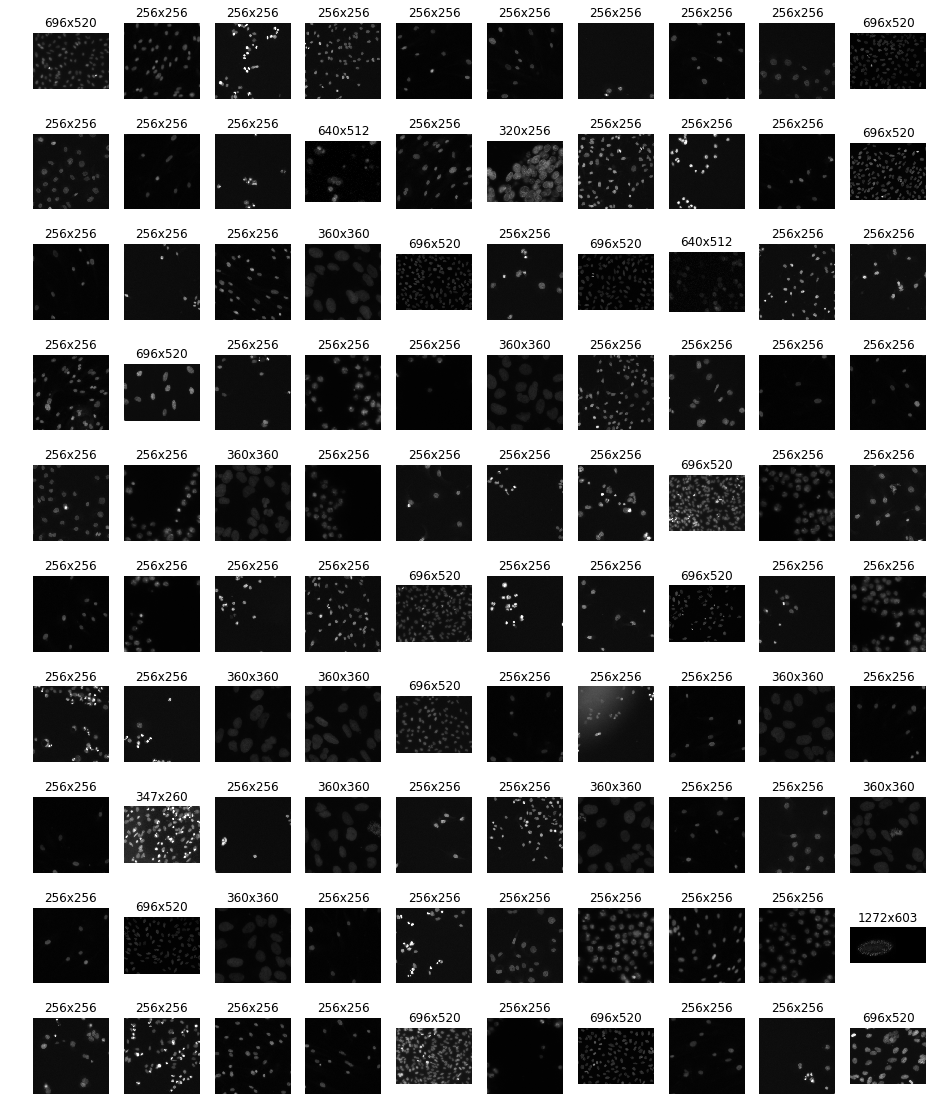

In [45]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 10, 10)

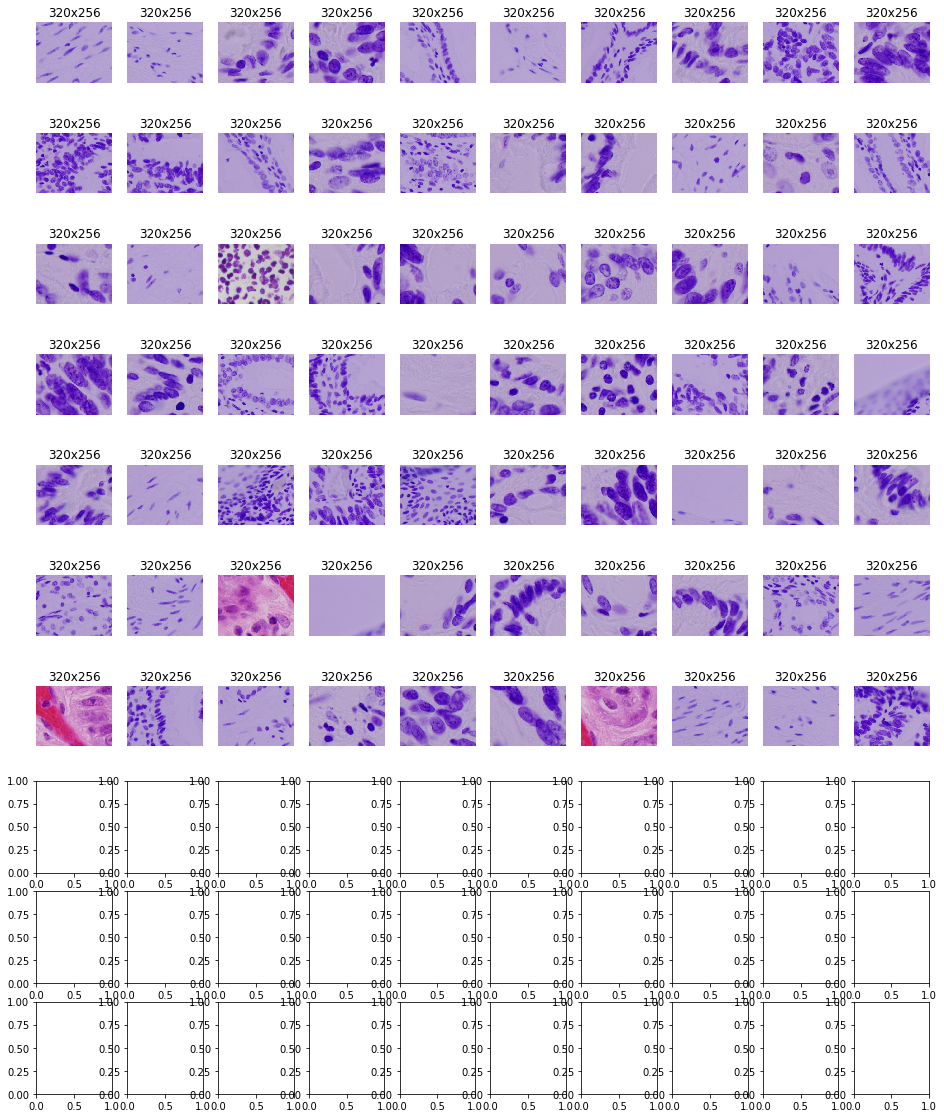

In [46]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 1][IMAGE_ID].values, 10, 10)

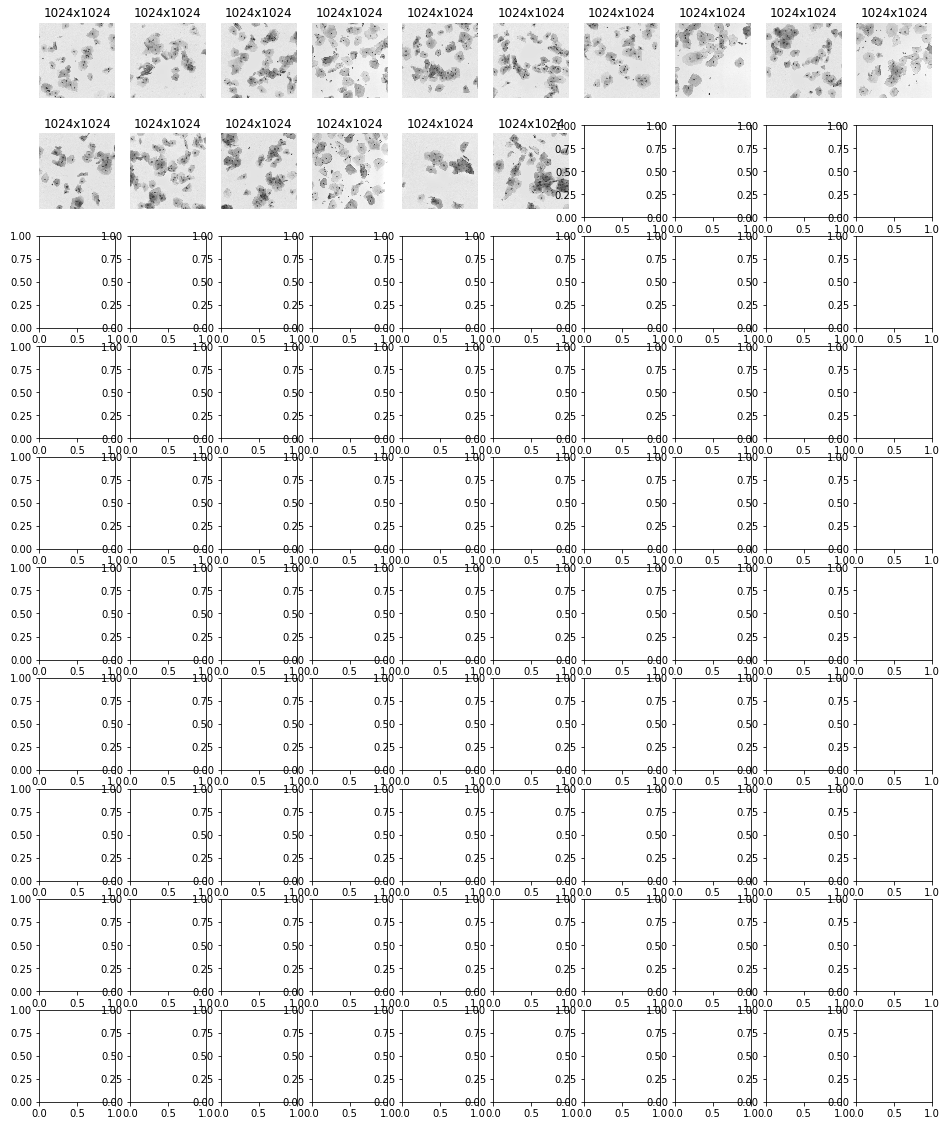

In [47]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 2][IMAGE_ID].values, 10, 10)

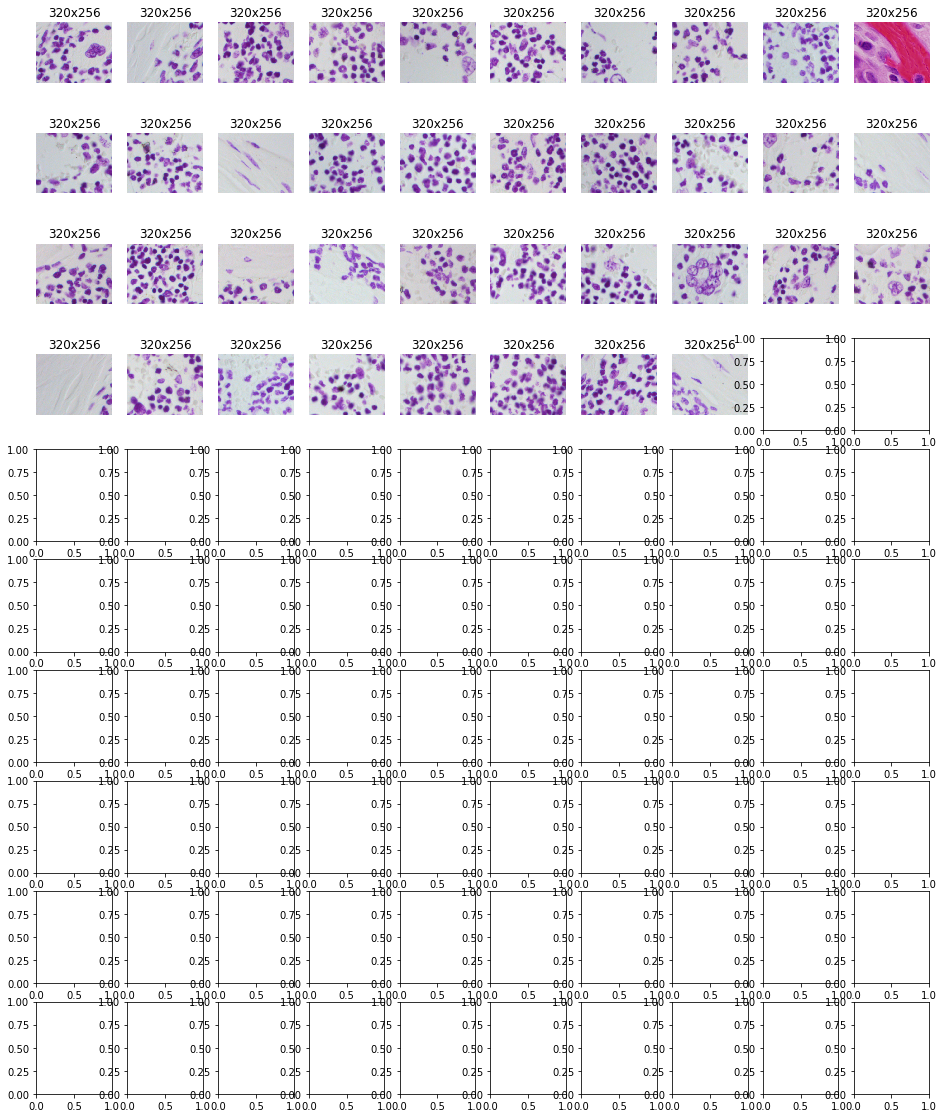

In [48]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 3][IMAGE_ID].values, 10, 10)

In [75]:
#plot_images(trainPD[trainPD[HSV_CLUSTER] == 4][IMAGE_ID].values, 1, 1)

In [76]:
#plot_images(trainPD[trainPD[HSV_CLUSTER] == 5][IMAGE_ID].values, 1, 1)

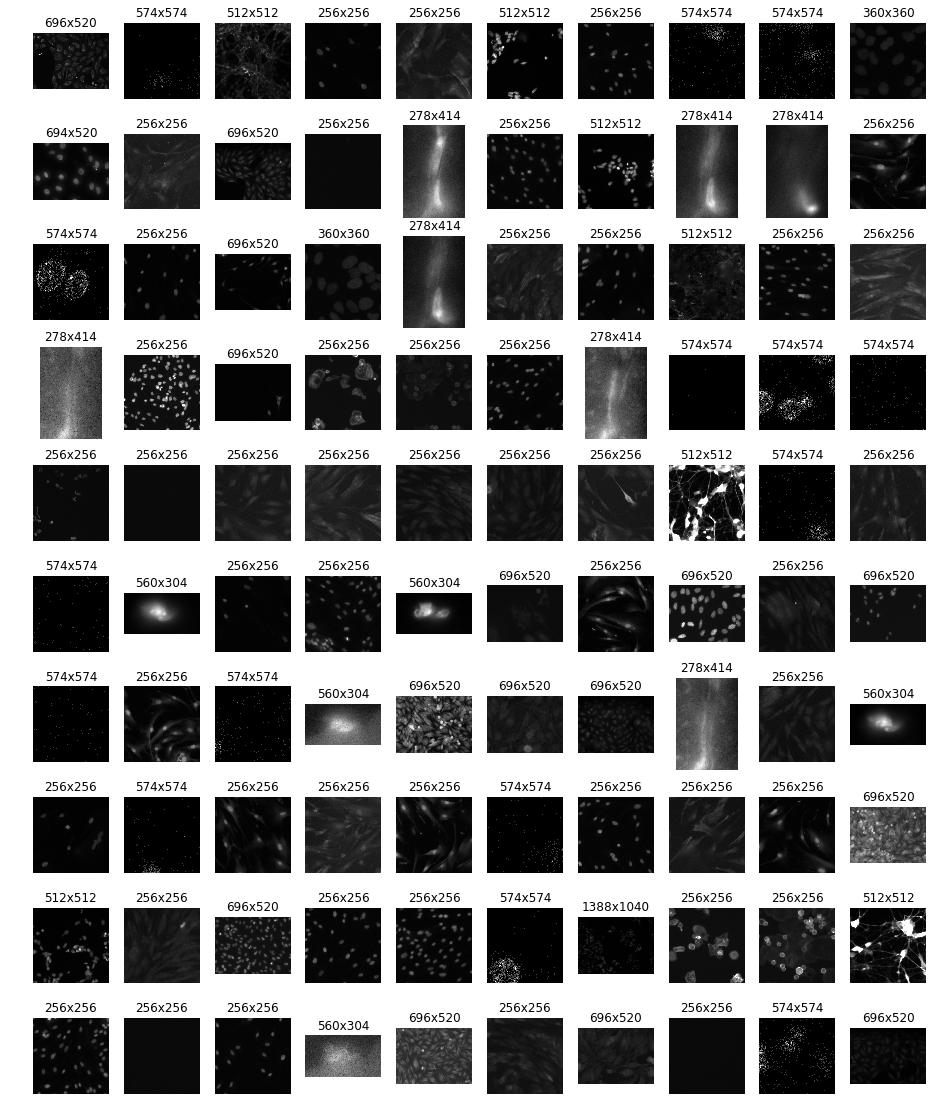

In [49]:
plot_images(testPD[testPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 10, 10, flag=False)

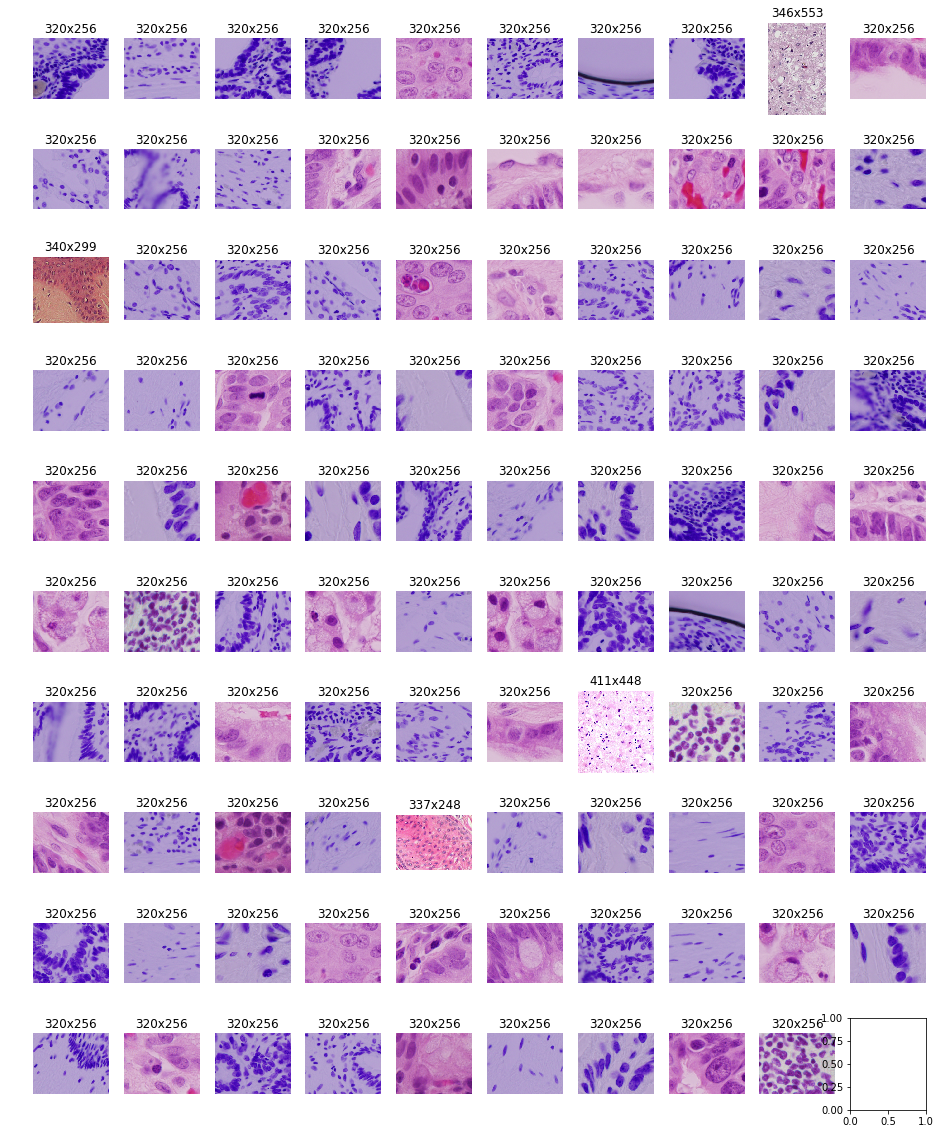

In [50]:
plot_images(testPD[testPD[HSV_CLUSTER] == 1][IMAGE_ID].values, 10, 10, flag=False)

ValueError: not enough values to unpack (expected 3, got 2)

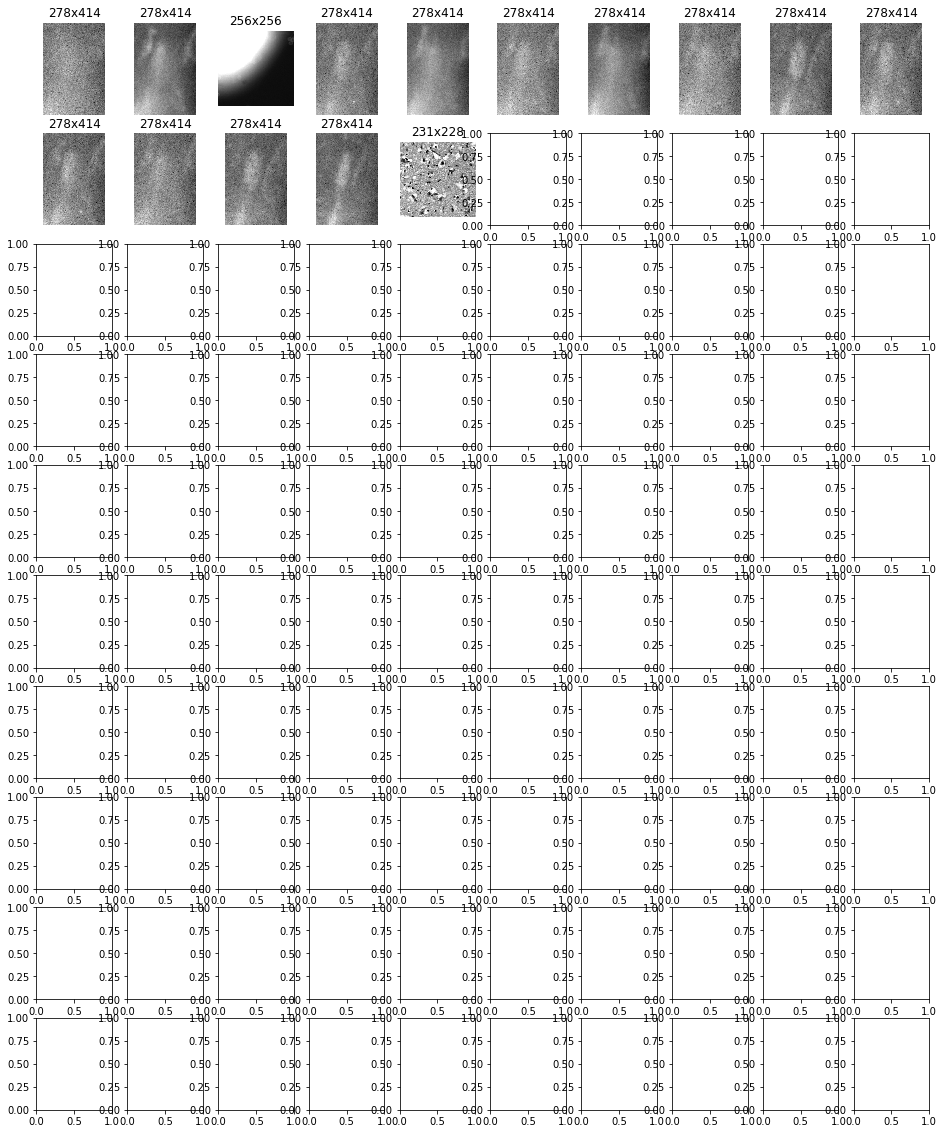

In [51]:
plot_images(testPD[testPD[HSV_CLUSTER] == 2][IMAGE_ID].values, 10, 10, flag=False)

In [80]:
#plot_images(testPD[testPD[HSV_CLUSTER] == 3][IMAGE_ID].values, 4, 4, flag=False)

In [81]:
#plot_images(testPD[testPD[HSV_CLUSTER] == 4][IMAGE_ID].values, 4, 4, flag=False)

In [82]:
#plot_images(testPD[testPD[HSV_CLUSTER] == 5][IMAGE_ID].values, 4, 4, flag=False)

In [83]:
tr34_ids = trainPD.loc[(trainPD[HSV_CLUSTER]==1)|(trainPD[HSV_CLUSTER]==3), 'image_id']
te34_ids = testPD.loc[(testPD[HSV_CLUSTER]==1)|(testPD[HSV_CLUSTER]==3), 'image_id']

In [84]:
np.shape(tr34_ids)

(108,)

In [85]:
def get_images_details2(image_ids, flag=True):
    details = []
    for image_id in image_ids:
        image_rgb = read_image_labels(image_id, space="rgb", flag=flag)
        height, width, l = image_rgb.shape
        #dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=2)
        #dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
        r = np.mean(image_rgb[:,:,0])
        g = np.mean(image_rgb[:,:,1])
        b = np.mean(image_rgb[:,:,2])

        rs = np.std(image_rgb[:,:,0])
        gs = np.std(image_rgb[:,:,1])
        bs = np.std(image_rgb[:,:,2])
        details.append([r, rs, b, bs])
    return details

In [86]:
tr_det = get_images_details2(tr34_ids)
te_det = get_images_details2(te34_ids, flag=False)

In [87]:
kmeans = KMeans(n_clusters=2).fit(tr_det)
clusters = kmeans.predict(tr_det)
clusterste = kmeans.predict(te_det)

In [88]:
clusters

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1],
      dtype=int32)

In [89]:
tr_c = []
te_c = []
for c in clusters:
    if c==0:
        tr_c.append(1)
    elif c==1:
        tr_c.append(3)
    elif c==2:
        tr_c.append(5)
        
for c in clusterste:
    if c==0:
        te_c.append(1)
    elif c==1:
        te_c.append(3)
    elif c==2:
        te_c.append(5)
        
tr_c = np.array(tr_c, dtype=np.int32)
te_c = np.array(te_c, dtype=np.int32)

In [90]:
np.shape(tr_c)

(108,)

In [91]:
for ids, c in zip(tr34_ids, tr_c):
    trainPD.loc[trainPD.image_id==ids, 'hsv_cluster']=c

In [92]:
for ids, c in zip(te34_ids, te_c):
    testPD.loc[testPD.image_id==ids, 'hsv_cluster']=c

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.01403708 0.01403708 0.01403708]
  [0.01483603 0.01483603 0.01483603]
  ...
  [0.00196078 0.00196078 0.00196078]
  [0.00310027 0.00310027 0.00310027]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.01023559 0.01023559 0.01023559]
  [0.01278275 0.01278275 0.01278275]
  ...
  [0.00219222 0.00219222 0.00219222]
  [0.00310027 0.00310027 0.00310027]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.00098039 0.00098039 0.00098039]
  [0.00294118 0.00294118 0.00294118]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00219222 0.00219222 0.00219222]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.00098039 0.00098039 0.00098039]


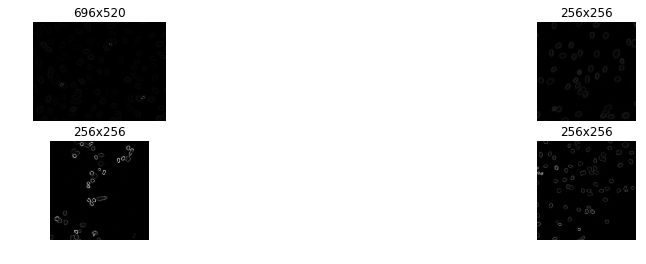

In [101]:
from skimage.filters import sobel
def plot_images2(images, images_rows, images_cols, flag=True):
    try:
        f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
        for row in range(images_rows):
            for col in range(images_cols):
                image_id = images[row*images_cols + col]
                image = read_image(image_id, train=flag)
                height, width, l = image.shape
                r = sobel(image[:,:,0])
                g = sobel(image[:,:,1])
                b = sobel(image[:,:,2])
                img = np.dstack([r,g,b])
                print(img)
                height, width, l = img.shape
                ax = axarr[row,col]
                ax.axis('off')
                ax.set_title("%dx%d"%(width, height))
                ax.imshow(img)
    except IndexError:
        pass

plot_images2(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 2, 2)

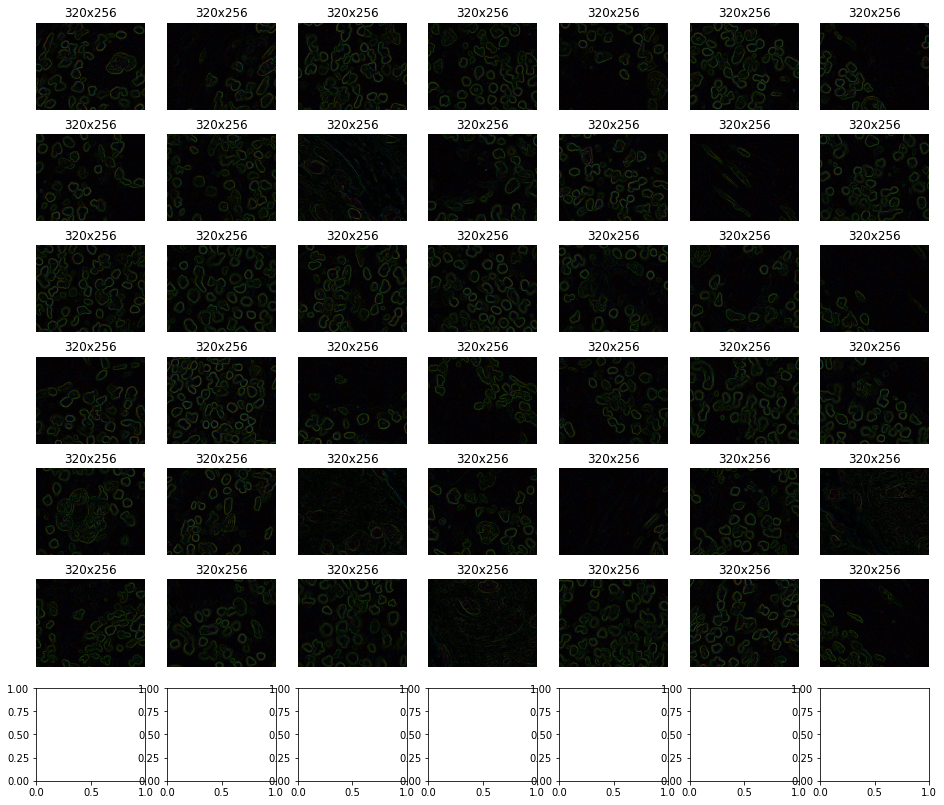

In [94]:
plot_images2(trainPD[trainPD[HSV_CLUSTER] == 3][IMAGE_ID].values, 7, 7)

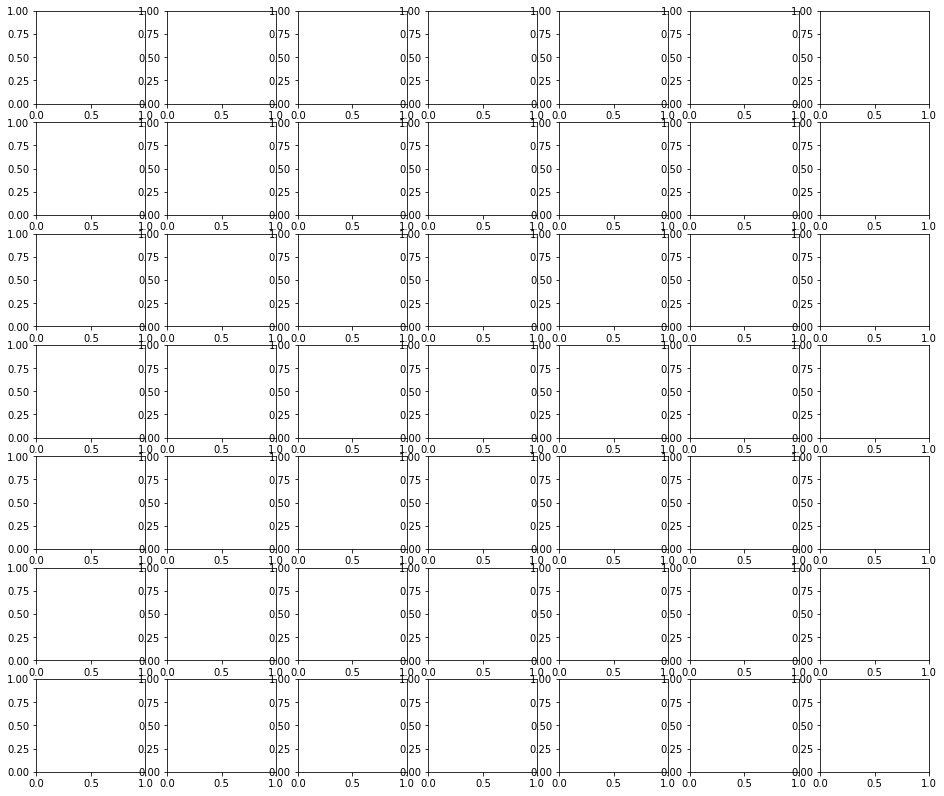

In [95]:
plot_images2(testPD[testPD[HSV_CLUSTER] == 1][IMAGE_ID].values, 7, 7, flag=False)

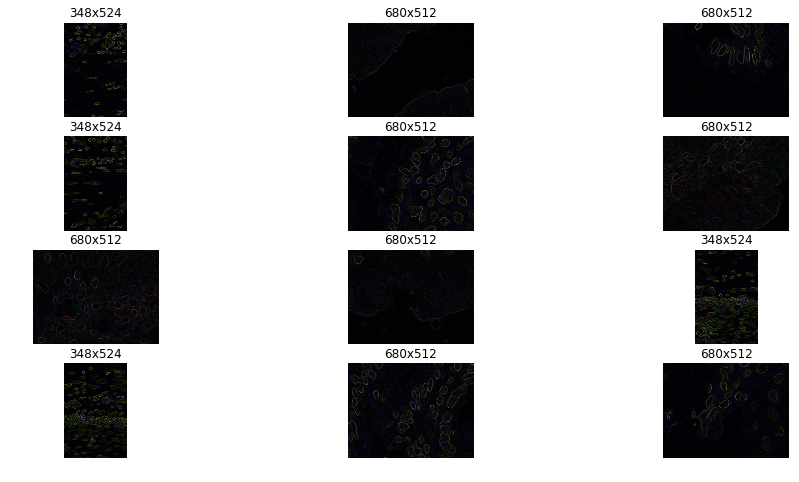

In [96]:
plot_images2(testPD[testPD[HSV_CLUSTER] == 3][IMAGE_ID].values, 4, 3, flag=False)

In [97]:
test_unique = testPD.hsv_cluster.unique()
test_unique

array([0, 3])

In [98]:
trainPD = trainPD.loc[(trainPD.hsv_cluster==test_unique[0]) | (trainPD.hsv_cluster==test_unique[1]), :]

In [99]:
train = trainPD.loc[:,['image_id', 'hsv_cluster']]
test = testPD.loc[:,['image_id', 'hsv_cluster']]

In [100]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [520]:
def get_images_details3(image_ids, flag=True):
    details = []
    for image_id in image_ids:
        image_rgb = read_image_labels(image_id, space="rgb", flag=flag)
        height, width, l = image_rgb.shape
        
        r = np.min(image_rgb[:,:,0]+image_rgb[:,:,1]+image_rgb[:,:,2])
        rk = np.std(image_rgb[:,:,0])
        rm = np.std(image_rgb[:,:,1])
        rs = np.std(image_rgb[:,:,2])
        details.append([rs, rm, rk])
    return details

In [521]:
tr3_ids = trainPD.loc[trainPD[HSV_CLUSTER]==0, 'image_id']
te3_ids = testPD.loc[testPD[HSV_CLUSTER]==0, 'image_id']

In [522]:
tr_det = get_images_details3(tr3_ids)
te_det = get_images_details3(te3_ids, flag=False)

In [523]:
kmeans = KMeans(n_clusters=3).fit(tr_det)
clusters = kmeans.predict(tr_det)
clusterste = kmeans.predict(te_det)

In [524]:
tr_c = []
te_c = []
for c in clusters:
    if c==0:
        tr_c.append(0)
    elif c==1:
        tr_c.append(1)
    elif c==2:
        tr_c.append(2)
    elif c==3:
        tr_c.append(4)
    elif c==4:
        tr_c.append(5)
    elif c==5:
        tr_c.append(6)
        
for c in clusterste:
    if c==0:
        te_c.append(0)
    elif c==1:
        te_c.append(1)
    elif c==2:
        te_c.append(2)
    elif c==3:
        te_c.append(4)
    elif c==4:
        te_c.append(5)
    elif c==5:
        te_c.append(6)
        
tr_c = np.array(tr_c, dtype=np.int32)
te_c = np.array(te_c, dtype=np.int32)

In [525]:
for ids, c in zip(tr3_ids, tr_c):
    trainPD.loc[trainPD.image_id==ids, 'hsv_cluster']=c

In [526]:
for ids, c in zip(te3_ids, te_c):
    testPD.loc[testPD.image_id==ids, 'hsv_cluster']=c

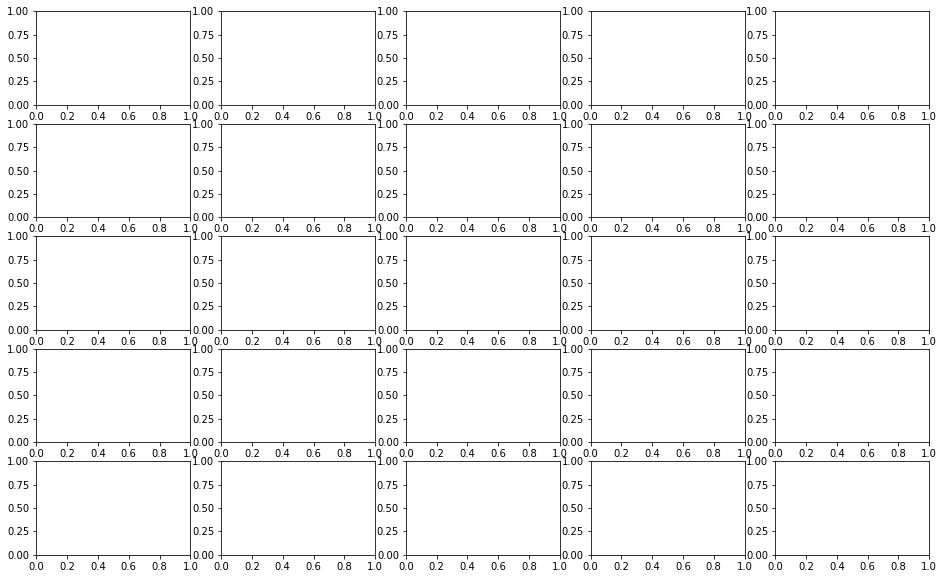

In [532]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 4][IMAGE_ID].values, 5, 5)

In [534]:
train = trainPD.loc[:,['image_id', 'hsv_cluster']]
test = testPD.loc[:,['image_id', 'hsv_cluster']]

In [535]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [536]:
train.hsv_cluster.unique()

array([0, 1, 3, 2])

In [537]:
test.hsv_cluster.unique()

array([1, 3, 0, 2])

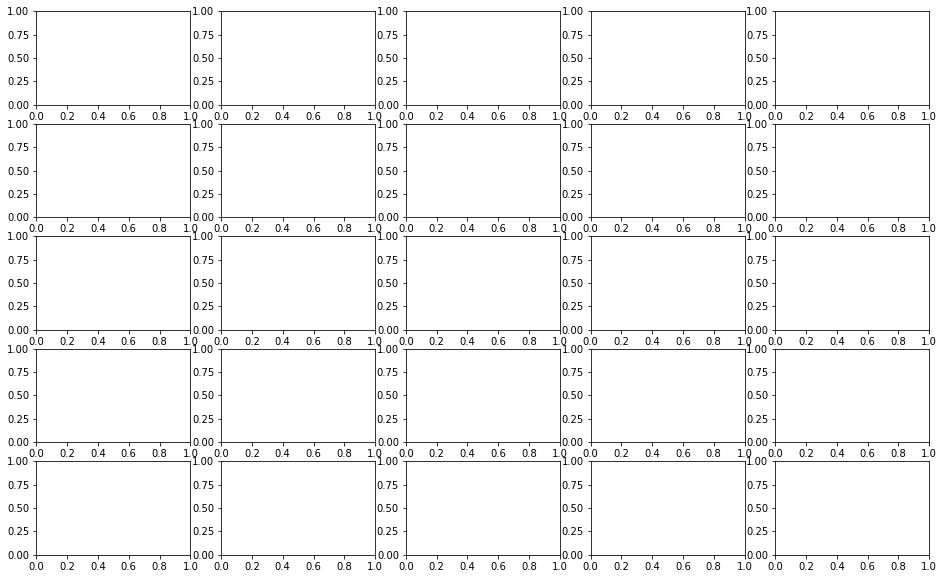

In [533]:
plot_images(testPD[testPD[HSV_CLUSTER] == 4][IMAGE_ID].values, 5, 5, flag=False)

In [ ]:
def get_images_details4(image_ids, flag=True):
    details = []
    for image_id in image_ids:
        image_rgb = read_image_labels(image_id, space="rgb", flag=flag)
        height, width, l = image_rgb.shape
        #dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=2)
        #dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
        r = np.std(image_rgb[:,:,0]+image_rgb[:,:,1]+image_rgb[:,:,2])
        g = np.median(image_rgb[:,:,0]+image_rgb[:,:,1]+image_rgb[:,:,2])
        bs = np.mean(image_rgb[:,:,0]+image_rgb[:,:,1]+image_rgb[:,:,2])
        details.append([r, bs, g])
    return details

In [ ]:
tr_det = get_images_details3(tr0_ids)
te_det = get_images_details3(te0_ids, flag=False)

In [ ]:
kmeans = KMeans(n_clusters=2).fit(tr_det)
clusters = kmeans.predict(tr_det)
clusterste = kmeans.predict(te_det)

In [ ]:
tr_c = []
te_c = []
for c in clusters:
    if c==0:
        tr_c.append(0)
    elif c==1:
        tr_c.append(2)
    elif c==2:
        tr_c.append(4)
        
for c in clusterste:
    if c==0:
        te_c.append(0)
    elif c==1:
        te_c.append(2)
    elif c==2:
        te_c.append(4)
        
tr_c = np.array(tr_c, dtype=np.int32)
te_c = np.array(te_c, dtype=np.int32)

In [ ]:
for ids, c in zip(tr0_ids, tr_c):
    trainPD.loc[trainPD.image_id==ids, 'hsv_cluster']=c

In [ ]:
for ids, c in zip(te0_ids, te_c):
    testPD.loc[testPD.image_id==ids, 'hsv_cluster']=c

In [ ]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 10, 10)

In [ ]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 2][IMAGE_ID].values, 10, 10)

In [ ]:
plot_images(testPD[testPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 4, 4, flag=False)

In [ ]:
plot_images(testPD[testPD[HSV_CLUSTER] == 2][IMAGE_ID].values, 4, 4, flag=False)

In [ ]:
train = trainPD.loc[:,['image_id', 'hsv_cluster']]
test = testPD.loc[:,['image_id', 'hsv_cluster']]

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
test_unique = test.hsv_cluster.unique()
test_unique

In [ ]:
train = train.loc[(train.hsv_cluster==test_unique[0]) | (train.hsv_cluster==test_unique[1])| (train.hsv_cluster==test_unique[2])| (train.hsv_cluster==test_unique[3]), :]

In [ ]:
train.head()

In [ ]:
train.hsv_cluster.unique()

In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [ ]:
len(train[train.hsv_cluster==0])

In [ ]:
len(train[train.hsv_cluster==1])

In [ ]:
len(train[train.hsv_cluster==2])

In [ ]:
len(train[train.hsv_cluster==3])

In [ ]:
len(test[test.hsv_cluster==0])

In [ ]:
len(test[test.hsv_cluster==1])

In [ ]:
len(test[test.hsv_cluster==2])

In [ ]:
len(test[test.hsv_cluster==3])